f (-64, 63)
DEBUG
%0 = x                   # EncryptedScalar<int7>         ∈ [-64, 62]
%1 = subgraph(%0)        # EncryptedScalar<uint3>        ∈ [0, 4]
return %1

Subgraphs:

    %1 = subgraph(%0):

        %0 = input                            # EncryptedScalar<int7>
        %1 = astype(%0, dtype=float64)        # EncryptedScalar<float64>
        %2 = util(%1)                         # EncryptedScalar<float64>
        %3 = astype(%2, dtype=int_)           # EncryptedScalar<uint1>
        return %3

PROCESSING NODE


100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1515.28it/s]

best_a[best_indexes]=65536 best_b[best_indexes]=-327680 best_lsbs[indexes]=18 best_msbs[indexes]=6 best_acc[indexes]=24
bounds=array([-64,  62])
bit_width(scale_up(subgraph_inputs, a=best_a, b=best_b))=24
msbs_to_keep=6, lsbs_to_remove=18
best_a.shape=(), ()
a_int.max()=65536
a_node.bounds=(-64, 62)
res_bounds=array([-4194304,  4063232])
bit_width(res_bounds)=23
b_int.max()=-327680
a_node.bounds=(-4194304, 4063232)
res_bounds=array([-3866624,  4390912])
bit_width(res_bounds)=24
lsbs_to_remove=18
DEBUG
%0 = x                                                                                                          # EncryptedScalar<int7>         ∈ [-64, 62]
%1 = 65536                                                                                                      # ClearScalar<uint17>
%2 = multiply(%0, %1)                                                                                           # EncryptedScalar<int23>        ∈ [-4194304, 4063232]
%3 = -327680                         


PROCESSING NODE


100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3266.59it/s]

best_a[best_indexes]=65536 best_b[best_indexes]=-327680 best_lsbs[indexes]=18 best_msbs[indexes]=6 best_acc[indexes]=24
bounds=array([-64,  62])
bit_width(scale_up(subgraph_inputs, a=best_a, b=best_b))=24
msbs_to_keep=6, lsbs_to_remove=18
best_a.shape=(), ()
a_int.max()=65536
a_node.bounds=(-64, 62)
res_bounds=array([-4194304,  4063232])
bit_width(res_bounds)=23
b_int.max()=-327680
a_node.bounds=(-4194304, 4063232)
res_bounds=array([-3866624,  4390912])
bit_width(res_bounds)=24
lsbs_to_remove=18
DEBUG
%0 = x                                                                                                    # EncryptedScalar<int7>         ∈ [-64, 62]
%1 = 65536                                                                                                # ClearScalar<uint17>
%2 = multiply(%0, %1)                                                                                     # EncryptedScalar<int23>        ∈ [-4194304, 4063232]
%3 = -327680                                           

DEBUG
%0 = x                                                                                                   # EncryptedScalar<int7>         ∈ [-64, 62]
%1 = round_bit_pattern(%0, lsbs_to_remove=1, overflow_protection=True, exactness=Exactness.EXACT)        # EncryptedScalar<int7>
%2 = subgraph(%1)                                                                                        # EncryptedScalar<uint3>        ∈ [0, 4]
return %2

Subgraphs:

    %2 = subgraph(%1):

        %0 = input                            # EncryptedScalar<int7>
        %1 = astype(%0, dtype=float64)        # EncryptedScalar<float64>
        %2 = util(%1)                         # EncryptedScalar<float64>
        %3 = astype(%2, dtype=int_)           # EncryptedScalar<uint1>
        return %3


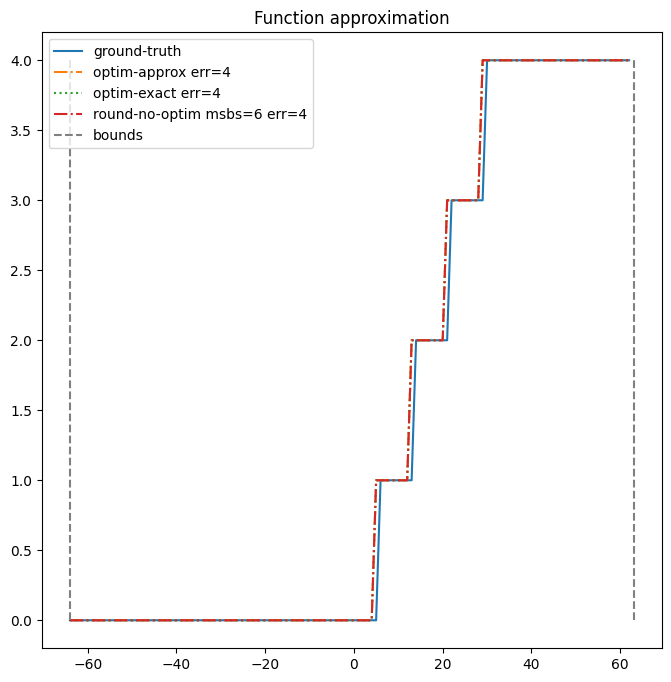

func_const (-64, 63)
DEBUG
%0 = x                   # EncryptedScalar<int7>         ∈ [-64, 62]
%1 = subgraph(%0)        # EncryptedScalar<uint1>        ∈ [0, 0]
return %1

Subgraphs:

    %1 = subgraph(%0):

         %0 = input                            # EncryptedScalar<int7>
         %1 = astype(%0, dtype=float64)        # EncryptedScalar<float64>
         %2 = 0.75                             # ClearScalar<float64>
         %3 = multiply(%2, %1)                 # EncryptedScalar<float64>
         %4 = 200                              # ClearScalar<uint8>
         %5 = subtract(%3, %4)                 # EncryptedScalar<float64>
         %6 = 0                                # ClearScalar<uint1>
         %7 = greater(%5, %6)                  # EncryptedScalar<uint1>
         %8 = multiply(%5, %7)                 # EncryptedScalar<float64>
         %9 = 118                              # ClearScalar<uint7>
        %10 = floor_divide(%8, %9)             # EncryptedScalar<float64>
    

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

best_a[best_indexes]=1 best_b[best_indexes]=0 best_lsbs[indexes]=6 best_msbs[indexes]=1 best_acc[indexes]=7
bounds=array([-64,  62])
bit_width(scale_up(subgraph_inputs, a=best_a, b=best_b))=7
msbs_to_keep=1, lsbs_to_remove=6
best_a.shape=(), ()
a_int.max()=1
b_int.max()=0
lsbs_to_remove=6
DEBUG
%0 = x                                                                                                         # EncryptedScalar<int7>         ∈ [-64, 62]
%1 = round_bit_pattern(%0, lsbs_to_remove=6, exactness=Exactness.APPROXIMATE, overflow_protection=True)        # EncryptedScalar<int7>         ∈ [-64, 62]
%2 = subgraph(%1)                                                                                              # EncryptedScalar<uint1>        ∈ [0, 0]
return %2

Subgraphs:

    %2 = subgraph(%1):

         %0 = input                            # EncryptedScalar<int7>
         %1 = astype(%0, dtype=float64)        # EncryptedScalar<float64>
         %2 = 0.75                             # C


PROCESSING NODE


100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

best_a[best_indexes]=1 best_b[best_indexes]=0 best_lsbs[indexes]=6 best_msbs[indexes]=1 best_acc[indexes]=7
bounds=array([-64,  62])
bit_width(scale_up(subgraph_inputs, a=best_a, b=best_b))=7
msbs_to_keep=1, lsbs_to_remove=6
best_a.shape=(), ()
a_int.max()=1
b_int.max()=0
lsbs_to_remove=6
DEBUG
%0 = x                                                                                                   # EncryptedScalar<int7>         ∈ [-64, 62]
%1 = round_bit_pattern(%0, lsbs_to_remove=6, exactness=Exactness.EXACT, overflow_protection=True)        # EncryptedScalar<int7>         ∈ [-64, 62]
%2 = subgraph(%1)                                                                                        # EncryptedScalar<uint1>        ∈ [0, 0]
return %2

Subgraphs:

    %2 = subgraph(%1):

         %0 = input                            # EncryptedScalar<int7>
         %1 = astype(%0, dtype=float64)        # EncryptedScalar<float64>
         %2 = 0.75                             # ClearScalar<float64

DEBUG
%0 = x                                                                                                   # EncryptedScalar<int7>         ∈ [-64, 62]
%1 = round_bit_pattern(%0, lsbs_to_remove=6, overflow_protection=True, exactness=Exactness.EXACT)        # EncryptedScalar<int7>
%2 = subgraph(%1)                                                                                        # EncryptedScalar<uint1>        ∈ [0, 0]
return %2

Subgraphs:

    %2 = subgraph(%1):

         %0 = input                            # EncryptedScalar<int7>
         %1 = astype(%0, dtype=float64)        # EncryptedScalar<float64>
         %2 = 0.75                             # ClearScalar<float64>
         %3 = multiply(%2, %1)                 # EncryptedScalar<float64>
         %4 = 200                              # ClearScalar<uint8>
         %5 = subtract(%3, %4)                 # EncryptedScalar<float64>
         %6 = 0                                # ClearScalar<uint1>
         %7 = greater(%5

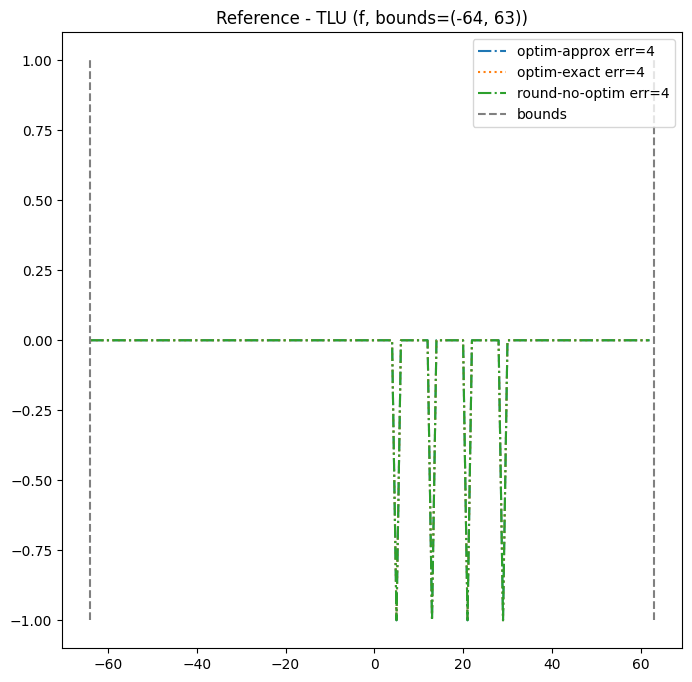

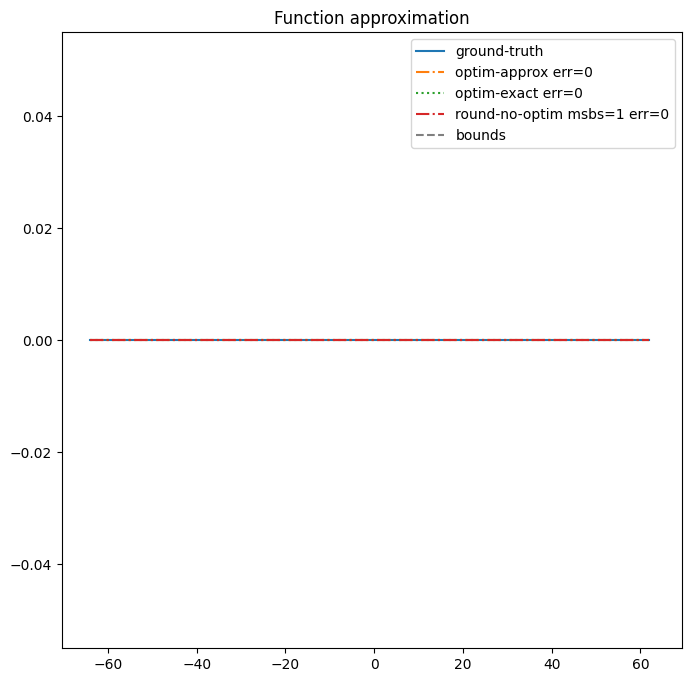

func_1_jump (-64, 63)
DEBUG
%0 = x                   # EncryptedScalar<int7>         ∈ [-64, 62]
%1 = subgraph(%0)        # EncryptedScalar<uint1>        ∈ [0, 0]
return %1

Subgraphs:

    %1 = subgraph(%0):

         %0 = input                            # EncryptedScalar<int7>
         %1 = astype(%0, dtype=float64)        # EncryptedScalar<float64>
         %2 = 0.75                             # ClearScalar<float64>
         %3 = multiply(%2, %1)                 # EncryptedScalar<float64>
         %4 = 0.0                              # ClearScalar<float64>
         %5 = add(%3, %4)                      # EncryptedScalar<float64>
         %6 = 0                                # ClearScalar<uint1>
         %7 = greater(%5, %6)                  # EncryptedScalar<uint1>
         %8 = multiply(%5, %7)                 # EncryptedScalar<float64>
         %9 = 118                              # ClearScalar<uint7>
        %10 = floor_divide(%8, %9)             # EncryptedScalar<float64>
 

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

best_a[best_indexes]=1 best_b[best_indexes]=0 best_lsbs[indexes]=6 best_msbs[indexes]=1 best_acc[indexes]=7
bounds=array([-64,  62])
bit_width(scale_up(subgraph_inputs, a=best_a, b=best_b))=7
msbs_to_keep=1, lsbs_to_remove=6
best_a.shape=(), ()
a_int.max()=1
b_int.max()=0
lsbs_to_remove=6
DEBUG
%0 = x                                                                                                         # EncryptedScalar<int7>         ∈ [-64, 62]
%1 = round_bit_pattern(%0, lsbs_to_remove=6, exactness=Exactness.APPROXIMATE, overflow_protection=True)        # EncryptedScalar<int7>         ∈ [-64, 62]
%2 = subgraph(%1)                                                                                              # EncryptedScalar<uint1>        ∈ [0, 0]
return %2

Subgraphs:

    %2 = subgraph(%1):

         %0 = input                            # EncryptedScalar<int7>
         %1 = astype(%0, dtype=float64)        # EncryptedScalar<float64>
         %2 = 0.75                             # C


PROCESSING NODE


100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

best_a[best_indexes]=1 best_b[best_indexes]=0 best_lsbs[indexes]=6 best_msbs[indexes]=1 best_acc[indexes]=7
bounds=array([-64,  62])
bit_width(scale_up(subgraph_inputs, a=best_a, b=best_b))=7
msbs_to_keep=1, lsbs_to_remove=6
best_a.shape=(), ()
a_int.max()=1
b_int.max()=0
lsbs_to_remove=6
DEBUG
%0 = x                                                                                                   # EncryptedScalar<int7>         ∈ [-64, 62]
%1 = round_bit_pattern(%0, lsbs_to_remove=6, exactness=Exactness.EXACT, overflow_protection=True)        # EncryptedScalar<int7>         ∈ [-64, 62]
%2 = subgraph(%1)                                                                                        # EncryptedScalar<uint1>        ∈ [0, 0]
return %2

Subgraphs:

    %2 = subgraph(%1):

         %0 = input                            # EncryptedScalar<int7>
         %1 = astype(%0, dtype=float64)        # EncryptedScalar<float64>
         %2 = 0.75                             # ClearScalar<float64

DEBUG
%0 = x                                                                                                   # EncryptedScalar<int7>         ∈ [-64, 62]
%1 = round_bit_pattern(%0, lsbs_to_remove=6, overflow_protection=True, exactness=Exactness.EXACT)        # EncryptedScalar<int7>
%2 = subgraph(%1)                                                                                        # EncryptedScalar<uint1>        ∈ [0, 0]
return %2

Subgraphs:

    %2 = subgraph(%1):

         %0 = input                            # EncryptedScalar<int7>
         %1 = astype(%0, dtype=float64)        # EncryptedScalar<float64>
         %2 = 0.75                             # ClearScalar<float64>
         %3 = multiply(%2, %1)                 # EncryptedScalar<float64>
         %4 = 0.0                              # ClearScalar<float64>
         %5 = add(%3, %4)                      # EncryptedScalar<float64>
         %6 = 0                                # ClearScalar<uint1>
         %7 = greater(

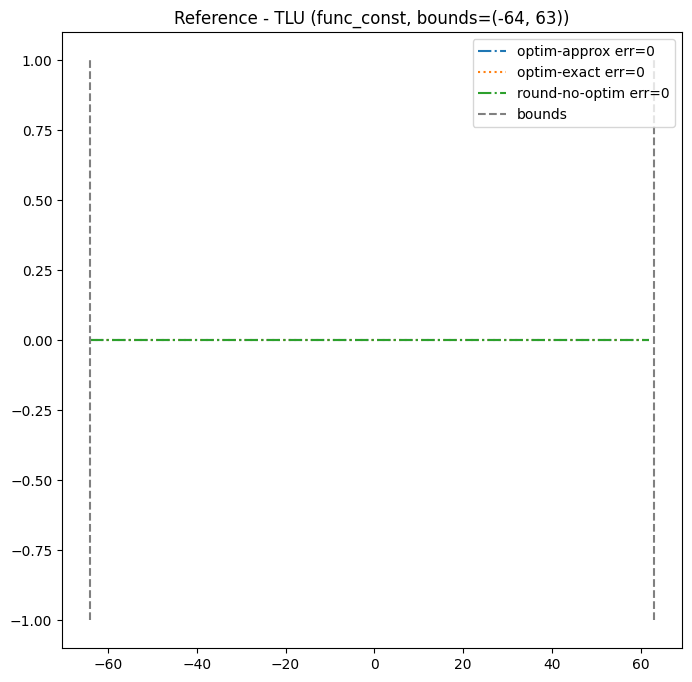

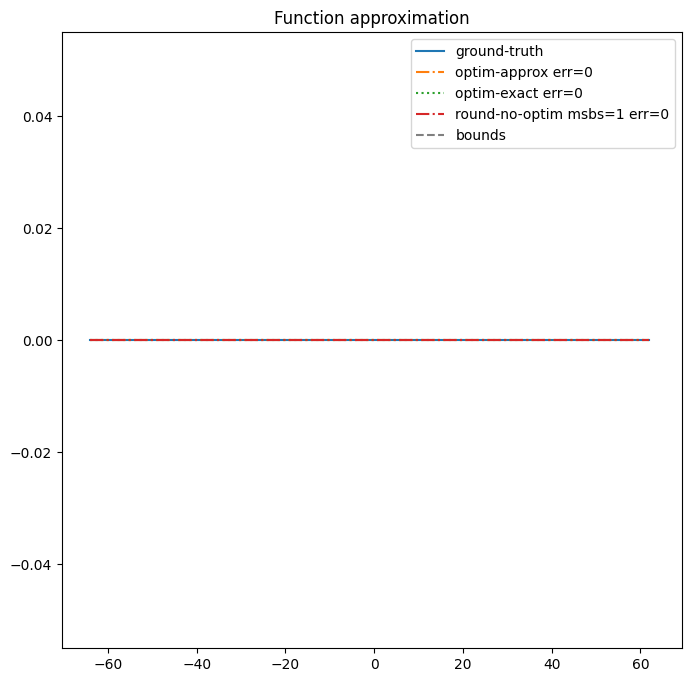

func_2_jump (-64, 63)
DEBUG
%0 = x                   # EncryptedScalar<int7>         ∈ [-64, 62]
%1 = subgraph(%0)        # EncryptedScalar<uint1>        ∈ [0, 1]
return %1

Subgraphs:

    %1 = subgraph(%0):

         %0 = input                            # EncryptedScalar<int7>
         %1 = astype(%0, dtype=float64)        # EncryptedScalar<float64>
         %2 = 0.75                             # ClearScalar<float64>
         %3 = multiply(%2, %1)                 # EncryptedScalar<float64>
         %4 = 134.0                            # ClearScalar<float64>
         %5 = add(%3, %4)                      # EncryptedScalar<float64>
         %6 = 0                                # ClearScalar<uint1>
         %7 = greater(%5, %6)                  # EncryptedScalar<uint1>
         %8 = multiply(%5, %7)                 # EncryptedScalar<float64>
         %9 = 118                              # ClearScalar<uint7>
        %10 = floor_divide(%8, %9)             # EncryptedScalar<float64>
 

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8422.30it/s]

best_a[best_indexes]=1 best_b[best_indexes]=107 best_lsbs[indexes]=8 best_msbs[indexes]=1 best_acc[indexes]=9
bounds=array([-64,  62])
bit_width(scale_up(subgraph_inputs, a=best_a, b=best_b))=9
msbs_to_keep=1, lsbs_to_remove=8
best_a.shape=(), ()
a_int.max()=1
b_int.max()=107
a_node.bounds=(-64, 62)
res_bounds=array([-171,  -45])
bit_width(res_bounds)=9
lsbs_to_remove=8
DEBUG
%0 = x                                                                                                         # EncryptedScalar<int7>         ∈ [-64, 62]
%1 = 107                                                                                                       # ClearScalar<uint7>
%2 = subtract(%0, %1)                                                                                          # EncryptedScalar<int9>         ∈ [-171, -45]
%3 = round_bit_pattern(%2, lsbs_to_remove=8, exactness=Exactness.APPROXIMATE, overflow_protection=True)        # EncryptedScalar<int9>         ∈ [-171, -45]
%4 = subgraph(%3)   


PROCESSING NODE


100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

best_a[best_indexes]=1 best_b[best_indexes]=107 best_lsbs[indexes]=8 best_msbs[indexes]=1 best_acc[indexes]=9
bounds=array([-64,  62])
bit_width(scale_up(subgraph_inputs, a=best_a, b=best_b))=9
msbs_to_keep=1, lsbs_to_remove=8
best_a.shape=(), ()
a_int.max()=1
b_int.max()=107
a_node.bounds=(-64, 62)
res_bounds=array([-171,  -45])
bit_width(res_bounds)=9
lsbs_to_remove=8
DEBUG
%0 = x                                                                                                   # EncryptedScalar<int7>         ∈ [-64, 62]
%1 = 107                                                                                                 # ClearScalar<uint7>
%2 = subtract(%0, %1)                                                                                    # EncryptedScalar<int9>         ∈ [-171, -45]
%3 = round_bit_pattern(%2, lsbs_to_remove=8, exactness=Exactness.EXACT, overflow_protection=True)        # EncryptedScalar<int9>         ∈ [-171, -45]
%4 = subgraph(%3)                           

DEBUG
%0 = x                                                                                                   # EncryptedScalar<int7>         ∈ [-64, 62]
%1 = round_bit_pattern(%0, lsbs_to_remove=6, overflow_protection=True, exactness=Exactness.EXACT)        # EncryptedScalar<int7>
%2 = subgraph(%1)                                                                                        # EncryptedScalar<uint1>        ∈ [0, 1]
return %2

Subgraphs:

    %2 = subgraph(%1):

         %0 = input                            # EncryptedScalar<int7>
         %1 = astype(%0, dtype=float64)        # EncryptedScalar<float64>
         %2 = 0.75                             # ClearScalar<float64>
         %3 = multiply(%2, %1)                 # EncryptedScalar<float64>
         %4 = 134.0                            # ClearScalar<float64>
         %5 = add(%3, %4)                      # EncryptedScalar<float64>
         %6 = 0                                # ClearScalar<uint1>
         %7 = greater(

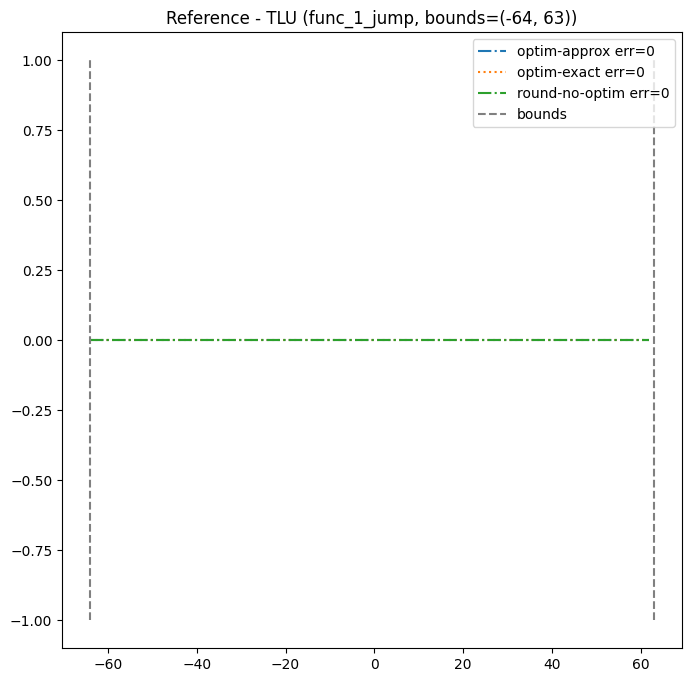

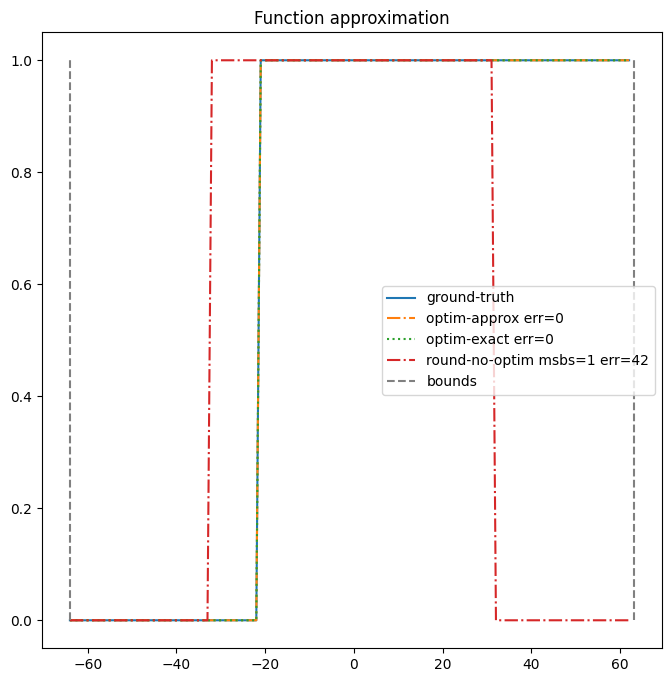

func_5_jump (-64, 63)
DEBUG
%0 = x                   # EncryptedScalar<int7>         ∈ [-64, 62]
%1 = subgraph(%0)        # EncryptedScalar<uint2>        ∈ [1, 3]
return %1

Subgraphs:

    %1 = subgraph(%0):

         %0 = input                            # EncryptedScalar<int7>
         %1 = astype(%0, dtype=float64)        # EncryptedScalar<float64>
         %2 = 0.75                             # ClearScalar<float64>
         %3 = multiply(%2, %1)                 # EncryptedScalar<float64>
         %4 = 163.0                            # ClearScalar<float64>
         %5 = add(%3, %4)                      # EncryptedScalar<float64>
         %6 = 0                                # ClearScalar<uint1>
         %7 = greater(%5, %6)                  # EncryptedScalar<uint1>
         %8 = multiply(%5, %7)                 # EncryptedScalar<float64>
         %9 = 69                               # ClearScalar<uint7>
        %10 = floor_divide(%8, %9)             # EncryptedScalar<float64>
 

100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2809.31it/s]

best_a[best_indexes]=91180 best_b[best_indexes]=-7294448 best_lsbs[indexes]=23 best_msbs[indexes]=1 best_acc[indexes]=24
bounds=array([-64,  62])
bit_width(scale_up(subgraph_inputs, a=best_a, b=best_b))=24
msbs_to_keep=1, lsbs_to_remove=23
best_a.shape=(), ()
a_int.max()=91180
a_node.bounds=(-64, 62)
res_bounds=array([-5835520,  5653160])
bit_width(res_bounds)=24
b_int.max()=-7294448
a_node.bounds=(-5835520, 5653160)
res_bounds=array([ 1458928, 12947608])
bit_width(res_bounds)=24
lsbs_to_remove=23
DEBUG
%0 = x                                                                                                          # EncryptedScalar<int7>          ∈ [-64, 62]
%1 = 91180                                                                                                      # ClearScalar<uint17>
%2 = multiply(%0, %1)                                                                                           # EncryptedScalar<int24>         ∈ [-5835520, 5653160]
%3 = -7294448                    


PROCESSING NODE


100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2716.52it/s]

best_a[best_indexes]=91180 best_b[best_indexes]=-7294448 best_lsbs[indexes]=23 best_msbs[indexes]=1 best_acc[indexes]=24
bounds=array([-64,  62])
bit_width(scale_up(subgraph_inputs, a=best_a, b=best_b))=24
msbs_to_keep=1, lsbs_to_remove=23
best_a.shape=(), ()
a_int.max()=91180
a_node.bounds=(-64, 62)
res_bounds=array([-5835520,  5653160])
bit_width(res_bounds)=24
b_int.max()=-7294448
a_node.bounds=(-5835520, 5653160)
res_bounds=array([ 1458928, 12947608])
bit_width(res_bounds)=24
lsbs_to_remove=23
DEBUG
%0 = x                                                                                                    # EncryptedScalar<int7>          ∈ [-64, 62]
%1 = 91180                                                                                                # ClearScalar<uint17>
%2 = multiply(%0, %1)                                                                                     # EncryptedScalar<int24>         ∈ [-5835520, 5653160]
%3 = -7294448                                      

DEBUG
%0 = x                                                                                                   # EncryptedScalar<int7>         ∈ [-64, 62]
%1 = round_bit_pattern(%0, lsbs_to_remove=6, overflow_protection=True, exactness=Exactness.EXACT)        # EncryptedScalar<int7>
%2 = subgraph(%1)                                                                                        # EncryptedScalar<uint2>        ∈ [1, 3]
return %2

Subgraphs:

    %2 = subgraph(%1):

         %0 = input                            # EncryptedScalar<int7>
         %1 = astype(%0, dtype=float64)        # EncryptedScalar<float64>
         %2 = 0.75                             # ClearScalar<float64>
         %3 = multiply(%2, %1)                 # EncryptedScalar<float64>
         %4 = 163.0                            # ClearScalar<float64>
         %5 = add(%3, %4)                      # EncryptedScalar<float64>
         %6 = 0                                # ClearScalar<uint1>
         %7 = greater(

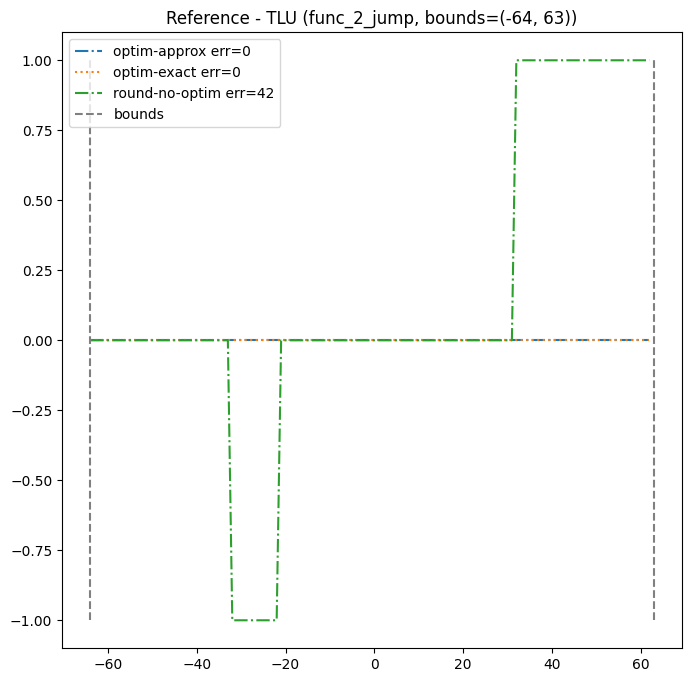

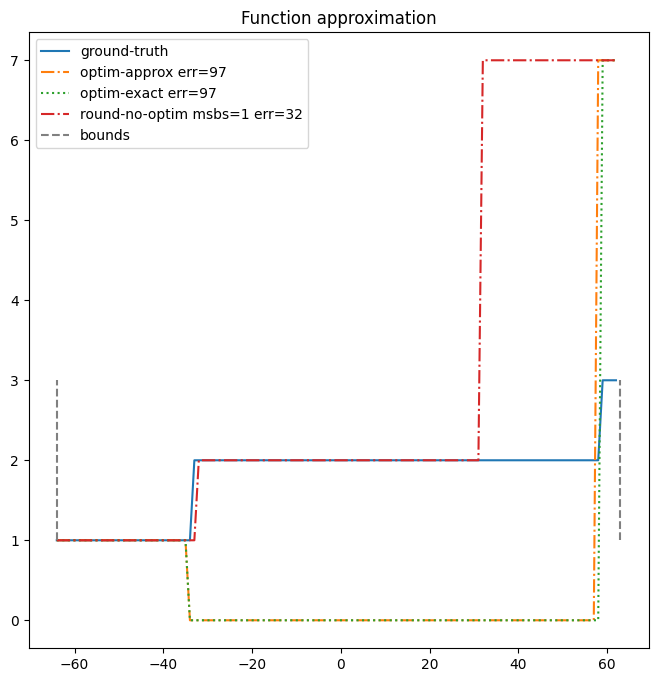

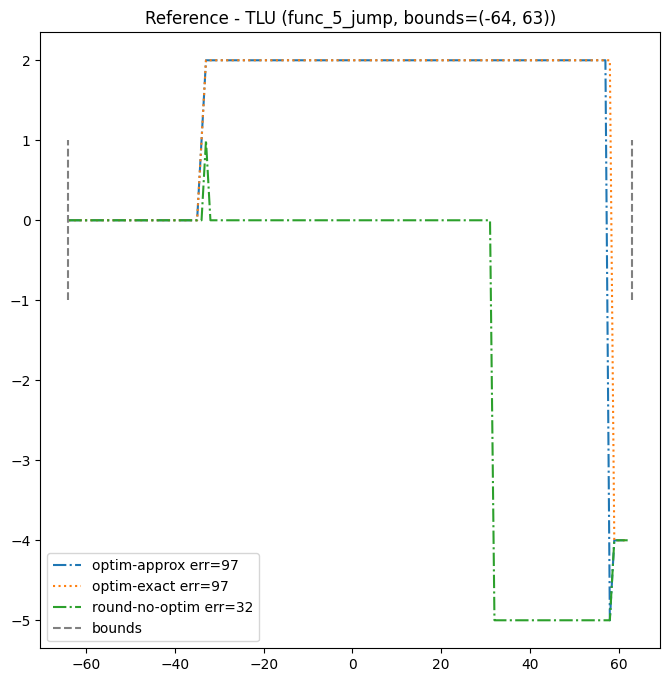

In [1]:
import matplotlib.pyplot as plt
import numpy
import numpy as np
from concrete.fhe import Configuration, Integer, univariate

from concrete import fhe
from concrete.ml.common.preprocessors import InsertRounding, TLUDeltaBasedOptimizer

np.random.seed(42)

input_range = (-234, 283)

inputset = np.arange(input_range[0], input_range[1], dtype=np.int64)
integer = Integer.that_can_represent(inputset)
full_range = np.arange(integer.min(), integer.max(), dtype=np.int64)

# Constant function


def func_const(x):
    x = x.astype(np.float64)
    x = 0.75 * x - 200
    x = x * (x > 0)
    x = x // 118
    # x = (x + 2.1) / 3.4
    x = np.rint(x)
    x = x.astype(np.int64)
    return x


# 2 jumps -> like what we have in CIFAR
def func_2_jump(x):
    x = x.astype(np.float64)
    x = 0.75 * x + 134.0
    x = x * (x > 0)
    x = x // 118
    # x = (x + 2.1) / 3.4
    x = np.rint(x)
    x = x.astype(np.int64)
    return x


# 1 jump
def func_1_jump(x):
    x = x.astype(np.float64)
    x = 0.75 * x + 0.0
    x = x * (x > 0)
    x = x // 118
    # x = (x + 2.1) / 3.4
    x = np.rint(x)
    x = x.astype(np.int64)
    return x


# 5 jumps
def func_5_jump(x):
    x = x.astype(np.float64)
    x = 0.75 * x + 163.0
    x = x * (x > 0)
    x = x // 69
    # x = (x + 2.1) / 3.4
    x = np.rint(x)
    x = x.astype(np.int64)
    return x


def make_step_function(n_thresholds, delta, x_min, x_max, power_of_two=False):
    """Make a step function using a TLU."""
    thresholds_ = []  # First threshold

    if power_of_two:
        th0 = numpy.random.randint(0, delta)
    else:
        th0 = numpy.random.randint(x_min, x_max)

    for index in range(n_thresholds):
        thresholds_.append(th0 + index * delta)

    thresholds = tuple(thresholds_)

    # Step size function to optimize
    def util(x):
        return sum([numpy.where(x >= float(threshold), 1.0, 0.0) for threshold in thresholds])

    def step_function(x):
        return univariate(util)(x).astype(numpy.int64)

    def f(x):
        return step_function(x.astype(numpy.float64))

    def constant_f(x):
        return univariate(lambda x: th0 * (1.0 - (x.astype(numpy.float64) * 0.0)))(x).astype(
            numpy.int64
        )

    if n_thresholds == 0:
        return constant_f
    return f


execution_number = 4
n_bits_from = execution_number + 2
for bounds in [
    (-(2 ** (n_bits_from)), (2 ** (n_bits_from)) - 1),
]:  # (-234, 283), (0, 283), (-283, 284), (-283, 0), (-62, 0), (0, 62)]:
    input_range = bounds
    x_min, x_max = bounds
    delta = 2 ** (n_bits_from // 2)  # Constant step size assumption
    for f in [
        make_step_function(execution_number, delta, x_min, x_max, True),
        func_const,
        func_1_jump,
        func_2_jump,
        func_5_jump,
    ]:
        print(f.__name__, bounds)
        inputset = np.arange(input_range[0], input_range[1], dtype=np.int64)
        integer = Integer.that_can_represent(inputset)
        full_range = np.arange(integer.min(), integer.max(), dtype=np.int64)
        full_range_to_range_mask = (full_range >= x_min) & (full_range <= x_max)

        def compute(circuit):
            Y = []
            X = []

            for x in full_range:
                y = circuit.simulate(x)
                X.append(x)
                Y.append(y)

            return np.array(Y)

        # Naive
        f_naive = fhe.compiler({"x": "encrypted"})(f)

        circuit_naive = f_naive.compile(inputset)

        naive_res = compute(circuit_naive)

        # Optim - Approx
        exactness = fhe.Exactness.APPROXIMATE
        optim = TLUDeltaBasedOptimizer(overflow_protection=True, exactness=exactness, verbose=1)
        pre_proc_optim = [optim]
        cfg_optim = Configuration(additional_pre_processors=pre_proc_optim)

        f_optim = fhe.compiler({"x": "encrypted"})(f)

        circuit_optim = f_optim.compile(inputset, configuration=cfg_optim)

        optim_res = compute(circuit_optim)

        # Optim - Res
        exactness = fhe.Exactness.EXACT
        optim_exact = TLUDeltaBasedOptimizer(
            overflow_protection=True, exactness=exactness, verbose=1
        )
        pre_proc_optim_exact = [optim_exact]
        cfg_optim_exact = Configuration(additional_pre_processors=pre_proc_optim_exact)

        f_optim_exact = fhe.compiler({"x": "encrypted"})(f)

        circuit_optim_exact = f_optim_exact.compile(inputset, configuration=cfg_optim_exact)

        optim_res_exact = compute(circuit_optim_exact)

        # Round (bit-width-from-optim)
        n_bits_round = (
            list(optim.statistics.values())[0]["msbs_to_keep"] if optim.statistics else None
        )
        rounding_from_optim_no_scaling = InsertRounding(n_bits_round, overflow_protection=True)
        pre_proc_round_from_optim_no_scaling = [rounding_from_optim_no_scaling]
        cfg_round_from_optim_no_scaling = Configuration(
            additional_pre_processors=pre_proc_round_from_optim_no_scaling
        )

        f_round_from_optim_no_scaling = fhe.compiler({"x": "encrypted"})(f)

        circuit_round_from_optim_no_scaling = f_round_from_optim_no_scaling.compile(
            inputset, configuration=cfg_round_from_optim_no_scaling
        )

        round_res_from_optim_no_scaling = compute(circuit_round_from_optim_no_scaling)

        # todo: only consider input range error
        optim_approx_error = (
            naive_res[full_range_to_range_mask] != optim_res[full_range_to_range_mask]
        ).sum()
        optim_exact_error = (
            naive_res[full_range_to_range_mask] != optim_res_exact[full_range_to_range_mask]
        ).sum()
        round_no_optim_error = (
            naive_res[full_range_to_range_mask]
            != round_res_from_optim_no_scaling[full_range_to_range_mask]
        ).sum()

        # Plot
        fig, ax = plt.subplots(figsize=(8, 8))
        plt.title("Function approximation")
        ax.plot(full_range, naive_res, label="ground-truth", linestyle="-")
        ax.plot(
            full_range, optim_res, label=f"optim-approx err={optim_approx_error}", linestyle="-."
        )
        ax.plot(
            full_range, optim_res_exact, label=f"optim-exact err={optim_exact_error}", linestyle=":"
        )
        ax.plot(
            full_range,
            round_res_from_optim_no_scaling,
            label=f"round-no-optim msbs={n_bits_round} err={round_no_optim_error}",
            linestyle="-.",
        )
        ax.vlines(
            input_range,
            np.min(naive_res),
            np.max(naive_res),
            color="grey",
            linestyle="--",
            label="bounds",
        )
        plt.legend()

        # Set the secondary ticks
        if False:
            lsbs_to_remove = (
                integer.bit_width - list(optim.statistics.values())[0]["optimized_bit_width"]
            )
            rounded_ticks = full_range[
                np.concatenate(
                    [
                        np.diff(
                            fhe.round_bit_pattern(full_range, lsbs_to_remove=lsbs_to_remove)
                        ).astype(bool),
                        np.array(
                            [
                                False,
                            ]
                        ),
                    ]
                )
            ]

            # Create secondary axes for the top ticks
            ax_top = ax.twiny()
            ax_top.set_xlim(
                ax.get_xlim()
            )  # Make sure the secondary axis has the same limits as the primary axis

            # Set the secondary ticks
            ax_top.set_xticks(rounded_ticks)

            # Customize appearance of secondary ticks
            ax_top.tick_params(which="minor", length=4, color="red")

        plt.show()

        fig, ax = plt.subplots(figsize=(8, 8))
        plt.title(f"Reference - TLU ({f.__name__}, {bounds=})")
        ax.plot(
            full_range,
            naive_res - optim_res,
            label=f"optim-approx err={optim_approx_error}",
            linestyle="-.",
        )
        ax.plot(
            full_range,
            naive_res - optim_res_exact,
            label=f"optim-exact err={optim_exact_error}",
            linestyle=":",
        )
        ax.plot(
            full_range,
            naive_res - round_res_from_optim_no_scaling,
            label=f"round-no-optim err={round_no_optim_error}",
            linestyle="-.",
        )
        ax.vlines(input_range, -1, 1, color="grey", linestyle="--", label="bounds")
        plt.legend()